In [1]:
# Original
#     https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py

In [2]:
from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Dense, Dropout, concatenate
from keras.optimizers import RMSprop

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

Using TensorFlow backend.


In [3]:
batch_size = 128
num_classes = 10
# epochs = 20
epochs = 5

In [4]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

60000 train samples
10000 test samples


In [5]:
x1_train = np.copy(x_train)
x2_train = np.copy(x_train)
x1_test = np.copy(x_test)
x2_test = np.copy(x_test)

In [6]:
# make 2 images from 1 image
x1_train[:, 392:] = 0.0
x2_train[:, :392] = 0.0

x1_test[:, 392:] = 0.0
x2_test[:, :392] = 0.0

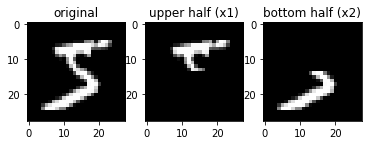

In [7]:
plt.subplot(1, 3, 1)
plt.title('original')
plt.imshow(x_train[0].reshape(28, 28), cmap=cm.gray)

plt.subplot(1, 3, 2)
plt.title('upper half (x1)')
plt.imshow(x1_train[0].reshape(28, 28), cmap=cm.gray)

plt.subplot(1, 3, 3)
plt.title('bottom half (x2)')
plt.imshow(x2_train[0].reshape(28, 28), cmap=cm.gray)

In [8]:
# Custom data generator
class MultiInputDataGenerator(object):
    def __init__(self, x1, x2, y, num_classes):
        self.x1 = x1
        self.x2 = x2
        self.y = y
        self.num_classes = num_classes
        self.length = len(self.x1)
        self.reset()
        assert len(self.x1) == len(self.x2) and len(self.x1) == len(self.y)
        
    def reset(self):
        self.inputs1 = []
        self.inputs2 = []
        self.labels = []
    
    def flow(self, batch_size=32, shuffle=True):
        if shuffle:
            indices = np.random.permutation(self.length)
            x1 = np.copy(self.x1)[indices]
            x2 = np.copy(self.x2)[indices]
            y = np.copy(self.y)[indices]
        else:
            x1 = self.x1
            x2 = self.x2
            y = self.y
            
        # No need to do this ?
        batch_num = self.length // batch_size
        x1 = x1[:batch_size * batch_num]
        x2 = x2[:batch_size * batch_num]
        y = y[:batch_size * batch_num]
        
        pos = 0
        while True:
            if pos == batch_size * batch_num:
                pos = 0
                
            self.inputs1.append(x1[pos])
            self.inputs2.append(x2[pos])
            self.labels.append(y[pos])
            pos = pos + 1
               
            if len(self.inputs1) == batch_size:
                inp1 = np.array(self.inputs1)
                inp2 = np.array(self.inputs2)
                labels = keras.utils.to_categorical(np.array(self.labels), self.num_classes)
                self.reset()
                yield [inp1, inp2], labels

In [9]:
def disp_images(images):
    for i, image in enumerate(images):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(image.reshape(28, 28), cmap=cm.gray)
        plt.xticks([])
        plt.yticks([])
    plt.show()

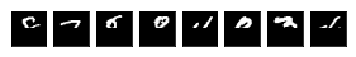

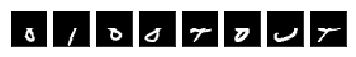

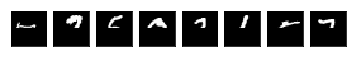

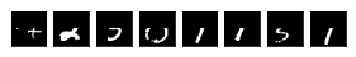

In [10]:
# Test generator 
gen_train = MultiInputDataGenerator(x1_train, x2_train, y_train, num_classes)

inputs, labels = gen_train.flow(batch_size=32).__next__() # In python2, use next() instead of __next__()
disp_images(inputs[0][:8])
disp_images(inputs[1][:8])

inputs, labels = gen_train.flow(batch_size=32).__next__() 
disp_images(inputs[0][:8])
disp_images(inputs[1][:8])

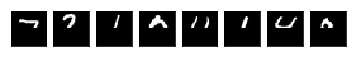

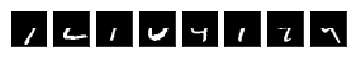

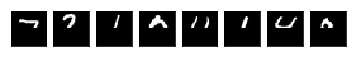

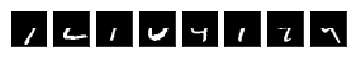

In [11]:
gen_test = MultiInputDataGenerator(x1_test, x2_test, y_test, num_classes)

inputs, labels = gen_test.flow(batch_size=32, shuffle=False).__next__() # In python2, use next() instead of __next__()
disp_images(inputs[0][:8])
disp_images(inputs[1][:8])

inputs, labels = gen_test.flow(batch_size=32, shuffle=False).__next__()
disp_images(inputs[0][:8])
disp_images(inputs[1][:8])

In [12]:
# Multi input model
inp_x1 = Input(shape=(784,))
inp_x2 = Input(shape=(784,))

x1 = Dense(512, activation='relu')(inp_x1)
x1 = Dropout(0.2)(x1)
x1 = Dense(512, activation='relu')(x1)
x1 = Dropout(0.2)(x1)

x2 = Dense(512, activation='relu')(inp_x2)
x2 = Dropout(0.2)(x2)
x2 = Dense(512, activation='relu')(x2)
x2 = Dropout(0.2)(x2)

merged = concatenate([x1, x2])
merged = Dense(256, activation='relu')(merged)
merged = Dropout(0.2)(merged)
out = Dense(num_classes, activation='softmax')(merged)

model = Model([inp_x1, inp_x2], out)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          401920      input_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 512)          401920      input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 

In [13]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

In [14]:
gen_train = MultiInputDataGenerator(x1_train, x2_train, y_train, num_classes)
gen_test = MultiInputDataGenerator(x1_test, x2_test, y_test, num_classes)

total_train_size = len(x1_train)
total_test_size = len(x1_test)

model.fit_generator(gen_train.flow(batch_size=batch_size), steps_per_epoch=total_train_size // batch_size,
                    validation_data=gen_test.flow(batch_size=batch_size, shuffle=False), validation_steps=total_test_size // batch_size,
                    epochs=epochs, verbose=1)

Epoch 1/5
468/468 [==============================] - 17s 36ms/step - loss: 0.2400 - acc: 0.9250 - val_loss: 0.1283 - val_acc: 0.9597
Epoch 2/5
468/468 [==============================] - 17s 37ms/step - loss: 0.0961 - acc: 0.9716 - val_loss: 0.0697 - val_acc: 0.9779
Epoch 3/5
468/468 [==============================] - 17s 36ms/step - loss: 0.0723 - acc: 0.9789 - val_loss: 0.0762 - val_acc: 0.9790
Epoch 4/5
468/468 [==============================] - 16s 35ms/step - loss: 0.0615 - acc: 0.9826 - val_loss: 0.0699 - val_acc: 0.9810
Epoch 5/5
468/468 [==============================] - 16s 35ms/step - loss: 0.0530 - acc: 0.9855 - val_loss: 0.0707 - val_acc: 0.9837


In [15]:
score = model.evaluate_generator(gen_test.flow(batch_size=batch_size, shuffle=False), steps=total_test_size // batch_size)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.0707444436371495
Test accuracy: 0.9836738782051282
